# Get communities over k to match the indicative scatter and indicative inv plots

In [2]:
import numpy as np
import os
import json
import sys
import matplotlib.pyplot as plt
import skimage

sys.path.append("../")
import src.plot as myplot
import seaborn as sns

import sklearn

In [3]:
import importlib
import src.plot as myplot
importlib.reload(myplot)

<module 'src.plot' from '/Users/paulhosek/PycharmProjects/mcm/MCM_classifier/Classifier_1/mcm/paper_plots/../src/plot.py'>

In [13]:

import importlib
import src.paper_utils as utils
importlib.reload(utils)

<module 'src.paper_utils' from '/Users/paulhosek/PycharmProjects/mcm/MCM_classifier/Classifier_1/mcm/paper_plots/../src/paper_utils.py'>

In [5]:
sample_sizes = [10, 100, 500,1000, 2000, 3000,4000,5000]
sample_sizes = [1000]
counts_samplesizes, mcms_samplesizes = utils.load_counts_mcm(sample_sizes, letter="", path_format="../data/OUTPUT/mcm/sample_sizes")
test_mcms, test_probs = utils.get_complete_testprobs(mcms_samplesizes,counts_samplesizes,sample_sizes,n_runs=2,smooth=True)

In [95]:
sample_idx = 0
run_idx = 0
digit_pair = [3,5]
all_byk_pair, all_byk_modspin, all_comms, all_dists = utils.get_all_byk_pair(test_probs, test_mcms, digit_pair, sample_idx, run_idx, return_comms=True,return_dists=True)
all_byk_pair = utils.adjust_smaller_icc(all_byk_pair,all_byk_modspin)

In [173]:
def kmask(dist_map, k):
    """
    Return 2d binary mask of the k icc furthest from the decision boundary.

    :param dist_map: The 2d distance map. 
    :type dist_map: 2d numpy.ndarray
    :param k: The number of icc to select.
    :type k: int
    :return: The masked array.
    :rtype: numpy.ndarray
    """
    thresh = np.sort(np.unique(dist_map.flat))[-k]
    msk = np.where(dist_map >= thresh, 1, 0)
    return msk 

def modelled_pixel_map(all_dists, all_comms, k):
    
    dist_maps = [all_dists[i][all_comms[i]] for i in range(2)]
    out = kmask(dist_maps[0], k) + kmask(dist_maps[1], k)*2
    return out



In [177]:
# modelled_pixel_map(all_dists, all_comms,1)

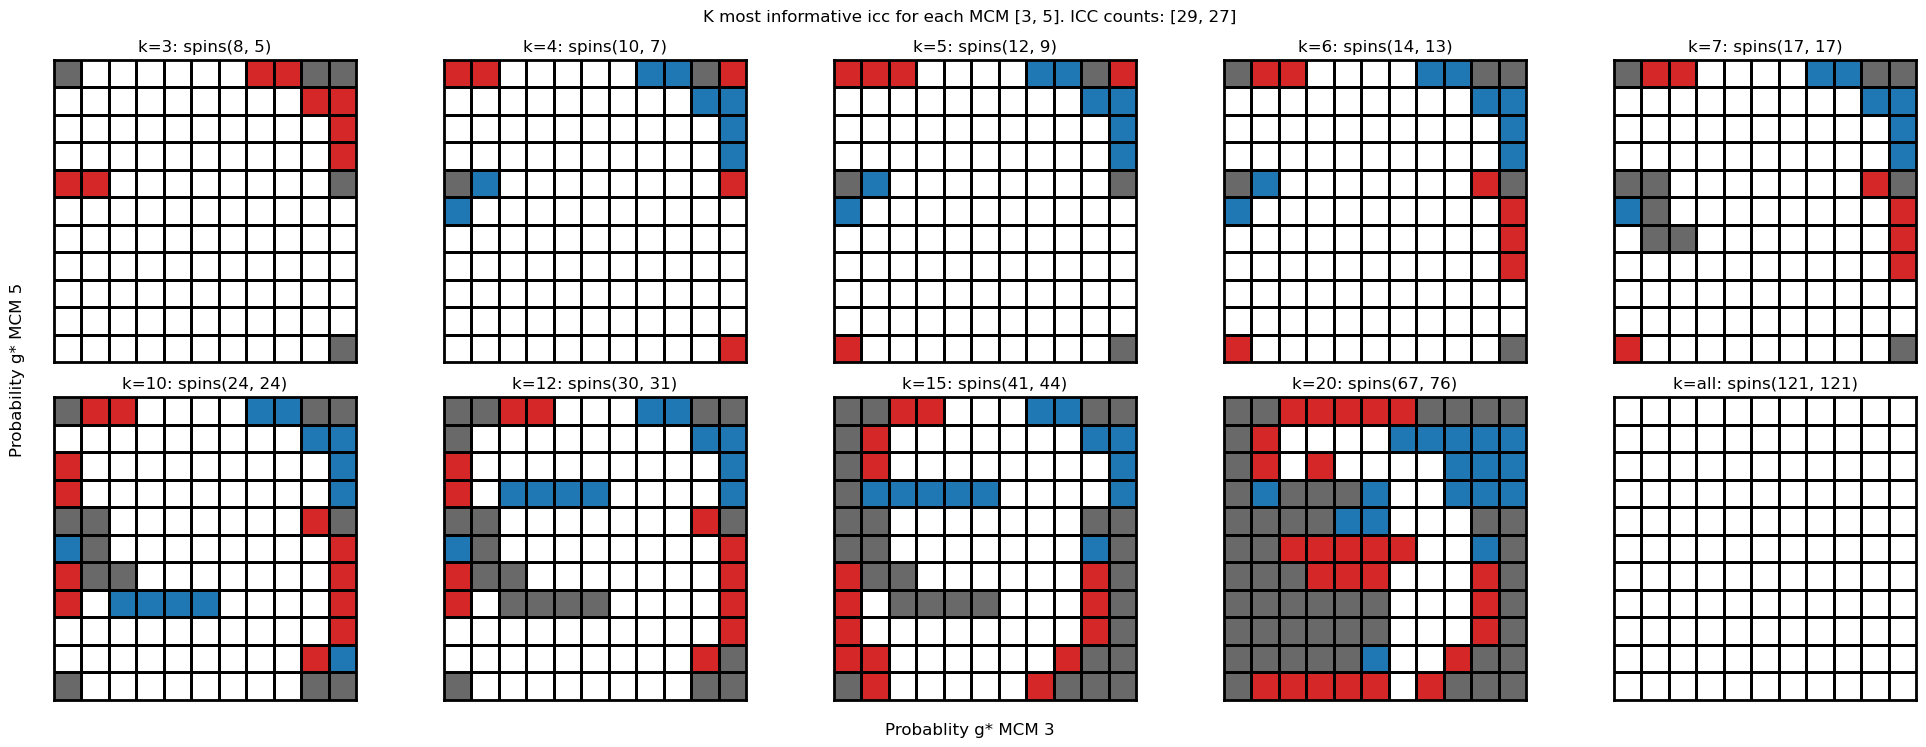

In [178]:
fig, axs = plt.subplots(2,5,figsize=(20,7.5))
axs = axs.ravel()
# len_shortest_mcm = np.min([len(i) for i in all_byk_pair])-1

top_ks = [3,4,5,6,7,
          10,12,15,20,0]
colors = myplot.get_default_colorcycle()
colors = ['white', colors[0], colors[3], "dimgrey"] #7B4F6E
cmap = ListedColormap(colors)

for j, k in enumerate(top_ks):
    ax = axs[j]

    pix_map = modelled_pixel_map(all_dists,all_comms,k)
    myplot.partition_map(ax, pix_map, None,borders=myplot.find_borders(np.arange(121).reshape((11,11))),cmap=cmap, normalise=False,cbar=None)

    ax.set_title(f"k={k if k!=0 else 'all'}: spins{all_byk_modspin[0][k-1], all_byk_modspin[1][k-1]}")
    
fig.supxlabel(f"Probablity g* MCM {digit_pair[0]}")
fig.supylabel(f"Probability g* MCM {digit_pair[1]}")


# plt.legend(title="Digit", bbox_to_anchor=(1.2,1,0,0))
fig.suptitle(f"K most informative icc for each MCM {digit_pair}. ICC counts: {[len(i) for i in  all_byk_modspin]}")
fig.tight_layout()

